In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.io import loadmat
import random
import pandas as pd


In [3]:
# Defining parameters

student_number = 5381827
student_number = list(str(student_number))
for i in range(len(student_number)):
    student_number[i] = int(student_number[i])
A, B, C, D, E, F, G = student_number


g = 9.81                    # Gravitational acceleration [m/s^2]
xi = 0.040 + C * 1e-3       # Damping ratio []
PGA = (0.33 + D * 1e-2)     # Peak ground acceleration [g]
gamma = 1.4                 # Importance factor [] - Importance class IV (assigned) corresponds to gamma=1.4 according to EN1998-1-1 (par 4.2.5)
a_g_ref = PGA*gamma         # Horizontal Reference acceleration [g] - Type 2 Earthquake (M_s = 5.0, assigned parameter)
a_vg_ref = a_g_ref*0.45     # Vertical Reference acceleration [g] - Type 2 Earthquake (M_s = 5.0, assigned parameter)

print(f"Damping ratio: {xi:.3}")
print(f"Peak Ground Acceleration (excluding importance factor): {PGA*g} m/s^2")
print(f"Horizontal Reference Acceleration for EN1998-1: {a_g_ref*g} m/s^2")
print(f"Vertical Reference Acceleration for EN1998-1: {a_vg_ref*g} m/s^2")

Damping ratio: 0.048
Peak Ground Acceleration (excluding importance factor): 3.3354000000000004 m/s^2
Horizontal Reference Acceleration for EN1998-1: 4.66956 m/s^2
Vertical Reference Acceleration for EN1998-1: 2.101302 m/s^2


1.0101525445522108


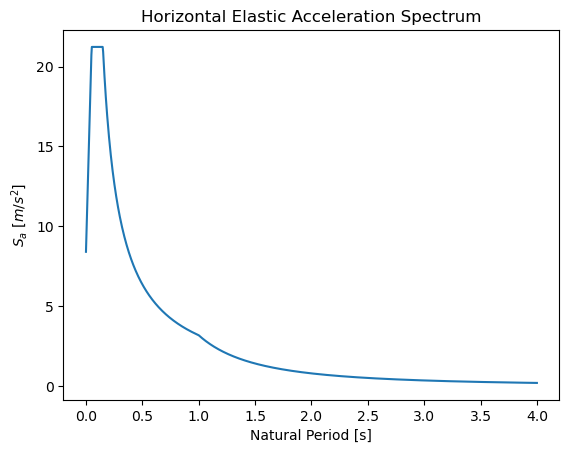

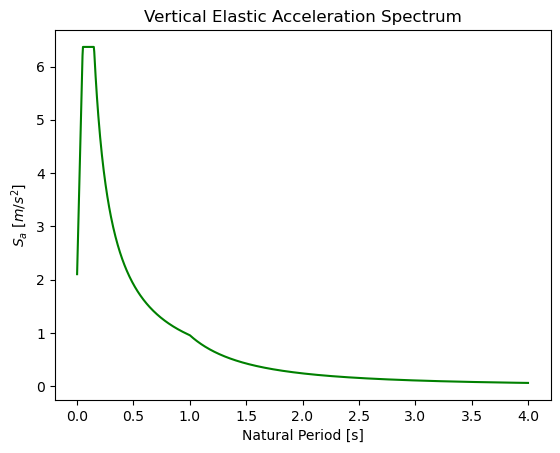

In [4]:
# Converting accelerations to m/s^2 for consistency with previous analysis
a_g_ref_ms2 = PGA*gamma*g        
a_vg_ref_ms2 = a_g_ref*0.45*g    

# Ground Type D - According to assignment input parameters

eta = np.sqrt(10/(5+xi*100))
print(eta)

S = 1.8
TB = 0.10
TC = 0.30
TD = 1.2
def horizontal_elastic_acc_spectrum(T, eta):
 Se_T_values = []
 for T in T:
   if 0 <= T <= TB:
      Se_T = a_g_ref_ms2 * S * (1 + (T / TB) * (eta * 2.5 - 1))
      Se_T_values.append(Se_T)
   elif TB < T <= TC:
      Se_T = a_g_ref_ms2 * S * eta * 2.5
      Se_T_values.append(Se_T)
   elif TC < T <= TD:
      Se_T = a_g_ref_ms2 * S * eta * 2.5 * (TC / T)
      Se_T_values.append(Se_T)
   elif TD < T <= 4.0:
      Se_T = a_g_ref_ms2 * S * eta * 2.5 * (TC * TD) / (T ** 2)
      Se_T_values.append(Se_T)
   else:
      Se_T = 0  # Or raise an exception or handle out-of-range T
      Se_T_values.append(Se_T)
 return Se_T_values


TB = 0.05 
TC = 0.15
TD = 1.0

def vertical_elastic_acceleration_response_spectrum(T, eta):
  Svd_T_values = []
  for T in T: 
      if 0 <= T <= TB:
           Svd_T = a_vg_ref_ms2 * (1 + (T / TB) * (eta * 3.0 - 1))
           Svd_T_values.append(Svd_T)
      elif TB < T <= TC:
          Svd_T = a_vg_ref_ms2 * eta * 3.0
          Svd_T_values.append(Svd_T)
      elif TC < T <= TD:
          Svd_T = a_vg_ref_ms2 * eta * 3.0 * (TC / T)
          Svd_T_values.append(Svd_T)
      elif TD < T:
          Svd_T = a_vg_ref_ms2 * eta * 3.0 * (TC * TD) / (T ** 2)
          Svd_T_values.append(Svd_T)
      else:
          Svd_T = 0  # Or handle as out-of-rang
          Svd_T_values.append(Svd_T)
  return Svd_T_values


T = np.linspace(0,4,1000)

plt.plot(T,horizontal_elastic_acc_spectrum(T,eta))
plt.title("Horizontal Elastic Acceleration Spectrum")
plt.xlabel(r'Natural Period [s]')
plt.ylabel(r'$S_a$ [$m/s^2$]')
plt.show()

plt.plot(T,vertical_elastic_acceleration_response_spectrum(T,eta),color='g')
plt.title("Vertical Elastic Acceleration Spectrum")
plt.xlabel(r'Natural Period [s]')
plt.ylabel(r'$S_a$ [$m/s^2$]')
plt.show()

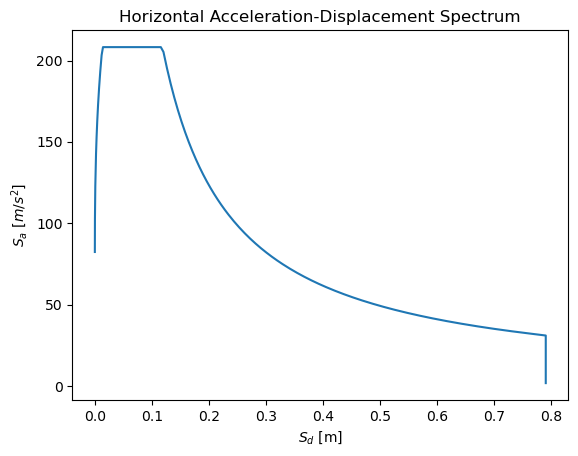

In [5]:
# Acceleration-Displacement Response Spectrum

S_a_hor_ms = g*np.array(horizontal_elastic_acc_spectrum(T, eta))
S_d_hor_ms = [T[i]**2*S_a_hor_ms[i]/(4*np.pi**2) for i in range(len(T))]

plt.plot(S_d_hor_ms,S_a_hor_ms)
plt.title("Horizontal Acceleration-Displacement Spectrum")
plt.xlabel(r'$S_d$ [m]')
plt.ylabel(r'$S_a$ [$m/s^2$]')
plt.show()

# Section 3.a
The pushover method of analysis is based on the imposition of a displacement pattern based either on uniform or modal deformed state. The standard operational procedure given by Eurocode 1998-1 begins with the derivation of the elastic spectrum based on a limited number of parameters that aim at predicting both Earthquake excitation and soil behavior. The first potential inconsistency when dealing with the Groningen seismic activity is that vertical accelerations are dominant in artificially induced Earthquakes, whereas the code assumes lateral excitations to be the critical design case (as can be seen in the coefficient table at 3.2.2.3 of EN1998-1). This particular feature is also relevant for the appropriate choice of mode to be used in the application of the modal displacement pattern. The pushover method relies on the ability of the single selected mode to describe the structural response to the excitation. In the case of the structure of interest the most critical loading condition is expected to be caused by lateral excitations, well represented by mode 1 and 2. These modes are however not able to represent properly the vertical component which is expected to be dominant in an Earthquake from the Groningen region. More generally, such considerations are especially crucial for structures whose stiffness relies on self-weight (i.e. a masonry structure with a disconnected roof). Another feature that may be relevant depending on the structure under analysis is that artificially induced earthquakes are characterized by high-energy release at higher frequencies, which may be a determining factor for the appropriate selection of modal pattern and is particularly important for short-period structures.

# Section 3.b

### Capacity vs Demand- Iterative procedure

### Figures

<table>
  <tr>
    <td>
      <figure>
        <img src="Figures/cvd1.png" width="400" alt="cvd1">
        <figcaption>Capacity vs Demand at given agR</figcaption>
      </figure>
    </td>
    <td>
      <figure>
        <img src="Figures/cvd2.png" width="400" alt="cvd2">
        <figcaption>Capacity vs Demand at agR=10</figcaption>
      </figure>
    </td>
  </tr>
  <tr>
    <td>
      <figure>
        <img src="Figures/cvd3.png" width="400" alt="capacity vs demand 3">
        <figcaption>Capacity vs Demand at agR=15</figcaption>
      </figure>
    </td>
    <td>
      <figure>
        <img src="Figures/cvd4.png" width="400" alt="capacity vs demand 4">
        <figcaption>Capacity vs Demand at agR=11...</figcaption>
      </figure>
    </td>
  </tr>
</table>



Our structure is able to withstand the acceleration imposed by EN1998-1 standard within its elastic regime. According to the simulation no plastic response is developed within failure. Upon further research, the conclusion that a more refined model would be necessary in order to develop a plastic phase in the capacity spectrum was reached. I would in fact be necessary to include a model of the connections in order to correctly reproduce structural collapse, whereas the current model can deform indefinitely. This was the interpretation given to the following diagram, where Von Mises equivalent stresses are plotted.

![pushover_no_plastic](Figures/POA_no_plastic_phase.png)

# Section 3.c

According to EN1998-1-2005 section 4.3.3.2.1 a single mode approximation is a viable option when the period of the chosen mode of vibration satisfies the following conditions:
$$
T_n<
\begin{cases}
4*T_C \\
2s
\end{cases}
$$
In our design scenario $T_C=0.3s$ and $4*T_C=1.2s$. Mode 2 was chosen for the analysis in X direction and respects the above mentioned condition with $T_2=0.27 s$. Mode 1 was chosen for the analysis in Y direction with $T_5=0.27 s$. No further load combinations are therefore deemed necessary.

## Section 4 - Time History Analysis
A Time History Analysis was carried out as part of the seismic assessment of the structure. Signal 1 was chosen from previously processed data and the model was subjected to the derived accelerations in the three principal directions.  
As part of this analysis a limitation of the RFEM software was encountered: the Stress-Analysis module did not support nonlinear material behavior for members. As a consequence the analysis was carried out in both bilinear and linear regimes, but stresses were computed for linear regime. It is therefore implicitly assumed that the linear behavior of the structure is sufficient to identify critical stresses location.

The comparison of **maximum displacements** yielded the following results:
|DOF|Member|Material Bilinear|Material Linear| Description |
|:-:|:-:|:-:|:-:|:--|
|X|313|-83.5 mm | -83.3 mm | Top of the tower|
|Y|365|87.0 mm |  86.3 mm | Antenna on mounting bracket |
|Z|329|-19.3 mm |  17.9 mm | Horizontal Bracing (2nd order) |
|$\phi_x$|365|41.7 mrad |41.0 mrad | Antenna on mounting bracket |
|$\phi_y$|329|-18.4 mrad |17.5 mrad | Horizontal Bracing (2nd order) |
|$\phi_z$|119|-70.3 mrad |-70.6 mrad | Strut in basal truss (lowest) |

**Most relevant high stresses locations**:
| Member No. | Location x [m] | Stress Existing [N/mm2] | Stress Limit [N/mm2] | Stress Ratio $\eta$ [-] |
| :---------: | :--------------: | :----------------------:| :------------------: | :----------------: |
| 111        | 1.874          | 200.340                 | 235.000              | 0.853              |
| 117        | 0.000          | 201.047                 | 235.000              | 0.856              |
| 311        | 1.707          | 211.905                 | 235.000              | 0.902              |
| 312        | 0.000          | 215.914                 | 235.000              | 0.919              |
| 329        | 0.000          | 258.318                 | 235.000              | 1.099              |
| 331        | 1.354          | 258.399                 | 235.000              | 1.100              |

![THA - Critical Stresses Members](Figures/THA_critical_elements.png)

Displayed stresses were computed with Von Mises equivalent stresses criterion. Comparing stresses with yielding stress values for the chosen material shows that most critical excitation is located at the interface between Members 329-331. 
This is consistent with Spectral and Modal analysis results. Mode 41, which excites precisely members 329-331 as shown in the following figure, has in fact a period of $0.065 s$ which closely matches the peak frequency of the vertical component of the Elastic Response Spectrum computed for the chosen signal.

<div style="display: flex; flex-wrap: wrap; justify-content: space-around;">
  <img src="Figures/THA_def_mode41.png" alt="Mode 41 Def" style="width: 30%;">
  <img src="Figures/THA_signal1_mode41.png" alt="Mode 41 - ERS" style="width: 30%;">
</div>
<br>

In conclusion, the results of the Time Series Analyisis would hint towards a vulnerability of the structure to vertical accelerations and therefore inadequacy of the design to withstand seismic load. It is however worth pointing out that the peak stress observed in members 329-331 is the result of a resonance between the spectral component located at 15.38 Hz in Signal 1 and mode 41 of the structure. Given that Signal 1 shows an unusually high peak when compared to the other signals that were taken into consideration, this result may require further examination of the validity and/or statistical relevance of Signal 1 and the design may not need further refinement. If the signal were to be considered relevant, the possible options to mitigate the problem would include the use of stronger profiles for members 329-331 and/or damping devices that would target displacements at the intersection of member 329-331. In both cases the analysis should be repeated as both options may in principle affect the dynamic behavior of the structure, potentially relocating the critical section. 


# Section 5 - Response Spectrum Analysis
### Part A
<div style="display: flex; flex-wrap: wrap; justify-content: space-around;">
  <img src="Figures/MA_1.png" alt="Mode 1" style="width: 20%;">
  <img src="Figures/MA_2.png" alt="Mode 2" style="width: 20%;">
  <img src="Figures/MA_3.png" alt="Mode 3" style="width: 20%;">
  <img src="Figures/MA_4.png" alt="Mode 4" style="width: 20%;">
  <img src="Figures/MA_5.png" alt="Mode 5" style="width: 20%;">
</div>
<br>

| Mode Nr |NF| Modal Mass | EMM X | EMM Y | EMM Z | EMM $\phi_x$ | EMM $\phi_y$ | EMM $\phi_z$ | Factor X | Factor Y | Factor Z | Factor $\phi_X$ | Factor $\phi_Y$ | Factor $\phi_Z$ |
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
| 1 | 3.667 | 1683.0   | 89.4     | 3848.9   | 0.0      | 364106.00  | 7104.35    | 0.00     | 0.010    | 0.440    | 0.000     | 0.510     | 0.010     | 0.000     |
| 2 | 3.668 | 1682.2   | 3849.0   | 89.4     | 0.0      | 7102.31    | 364118.00  | 0.01     | 0.440    | 0.010    | 0.000     | 0.010     | 0.510     | 0.000     |
| 3 | 5.839 | 449.9    | 428.6    | 217.7    | 0.0      | 28487.50   | 41881.80   | 0.00     | 0.049    | 0.025    | 0.000     | 0.040     | 0.059     | 0.000     |
| 4 | 5.839 | 450.0    | 217.7    | 428.5    | 0.0      | 41887.40   | 28488.40   | 0.00     | 0.025    | 0.049    | 0.000     | 0.059     | 0.040     | 0.000     |
| 5 | 5.855 | 544.5    | 0.0      | 0.0      | 0.0      | 0.00       | 0.00       | 0.00     | 0.000    | 0.000    | 0.000     | 0.000     | 0.000     | 0.000     |
| 28 | 12.026 | 0     | 0     | 0      | 0.4    | 0.16   | 10369   | 0     | 0     | 0     | 0      | 0      | 0      | 0.335  |
| 55 | 18.897 | 0     | 0.5   | 0.4    | 18.92  | 0.03   | 10792.4 | 0     | 0     | 0     | 0      | 0      | 0      | 0.349  |
| 84 | 25.518 | 0.2   | 0     | 3684.2 | 0.61   | 16.97  | 13.18   | 0     | 0     | 0.421 | 0      | 0      | 0      | 0      |

Inspecting the results of the modal analysis for 500 modes, the most relevant modes are mode 1 and 2 with a modal mass factor of 0.44 in for translational y and x direction respectively.
These modes are also relevant to describe the global bending behavior of the truss structure with a modal mass factor of 0.51 in rotational x-direction and y-direction respectively. The similarity in properties between the two modes is to be expected as a result of the highly symmetric geometry of the structure. Mode 3 and 4 concern deformations of the basal supports of the truss, however their contribution is secondarily relevant to describe the dynamic behavior of the structure and may be arguably excluded from the analysis. In fact, EN1998-1 recommends a threshold of 0.05 for the participation ratio in the selection of modes as part of the truncation process, however 0.049 is hereby regarded as a relatively high contribution for a single mode. Mode 5 is interpreted as a numerical artifact and therefore irrelevant. The first 5 modes are highly inadequate to describe the deformation of the structure in vertical and torsional directions (translation and rotation about z). The most relevant mode for the former direction would be mode 84 (with a mass participation ratio (z) of 0.421) while modes 28 and 55 are the main contributors for the latter direction (counter-clockwise and clockwise torsion) with mass participation ratio of 0.339 and 0.349 respectively.

### Part B

As mentioned in relation to Time History Analysis, due to RFEM features, maximum displacements were computed for both linear and nonlinear material, while stress-analysis was carried out for linear material only.
|DOF|Member|Material Bilinear|Material Linear| Description |
|:-:|:-:|:-:|:-:|:--|
|X| 321 | 61.3 mm  | 61.3 mm  | Top of tower |
|Y| 309 | 61.3 mm  | 61.3 mm  | Top of tower | 
|Z| 333 | 11.5 mm  | 11.5 mm  | Horizontal Bracing (1st order) |
|$\phi_x$| 239 | 12.0 mrad | 12.0 mrad | Strut in basal truss (2nd from bottom) |
|$\phi_y$| 177 | 12.0 mrad | 12.0 mrad | Strut in basal truss (2nd from bottom) |
|$\phi_z$| 181 | 36.5 mrad | 36.5 mrad | Strut in basal truss (lowest) |

<br>

|Critical Section|$U_x$|$U_y$|$U_z$|$\phi_x$|$\phi_y$|$\phi_z$|$\sigma_x$|$\sigma_y$|$\sigma_z$|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|
|
|

CQC method was preferred to the SRSS rule to combine structural modes. This choice was based on the robustness of CQC when dealing with modes of vibration close in frequency. Although the case at hand did not specifically require such attention CQC was the preferred choice as more reliable and advanced modelling option. Moreover a damping ratio of 5% was taken as a realistic assumption for all modes, setting the domain within the range of accuracy of the CQC method. Given the EN1998-1 spectra wide band range CQC was also deemed more appropriate to the specific design situation.
SRSS was in turn selected to combined different directional seismic components. This method was preferred to the absolute sum method, which was deemed over-conservative, and to the scaled sum method, which was discarded for its Sectionable approach to modelling the real physical relation between seismic components.


### Part C

An incremental number of modes was considered in order to obtain a 90% cumulative sum of modal participation factors, as recommended by EN1998-1. 
|N Modes|X|Y|Z|$\phi_x$|$\phi_y$|$\phi_z$|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|10|  52.44 %    | 52.40 %    |  0.28 %    | 61.85 %    | 61.86 %    |  5.69 %    |
|50|  72.97 %    | 73.01 %    |  2.26 %    | 70.04 %    | 70.02 %    | 43.17 %    |
|100| 96.24 %    | 96.31 %    | 46.66 %    | 92.35 %    | 92.24 %    | 83.58 %    |
|500| 98.01 %    | 98.01 %    | 79.69 %    | 96.39 %    | 96.40 %    | 93.43 %    |

The Response Spectrum Analysis was carried out with a 500 mode approximation. It is worth noting that the summation of mass ratios in the Z direction does not meet the recommended value. The main reason behind such truncation decision was ensuring computational manageability of the model. From a physical point of view, this modelling choice should not impact significantly the results of the analysis, since the truss nature of the structure should guarantee high resistance in the axial direction. Moreover, the dominant excitations imposed by EN1998-1 are horizontally directed, which further supports the implemented assumption, however this vulnerability should not go overlooked when vertical accelerations are relevant, as shown by the results of Time History Analysis where mode 41 proved to be determining.

Elaborating further on the sensitivity of the results to the number of modes used in the analysis, it can be observed comparing the previous and the following table that no difference is observed in the numerical results between 50, 100 and 500 (disclaimer: Member 115 is a symmetric counterpart of Member 239). A small numerical difference is instead recorded between 10 and 50 modes approximation.

|N Modes|Max Disp. X|Max Disp. Y|Max Disp. Z|Max Disp. $\phi_x$|Max Disp. $\phi_y$|Max Disp. $\phi_z$|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
| 10| 61.4 mm Member No. 313 | 70.1 mm Member No. 365 | 11.5 mm Member No. 365 | 25.5 mrad Member No. 365 | 11.9 mrad Member No. 301 | 36.4 mrad Member No. 119 |
| 50 | 61.3 mm Member No. 313 | 61.3 mm Member No. 309 | 11.5 mm Member No. 333 | 12.0 mrad Member No. 115 | 12.0 mrad Member No. 177 | 36.5 mrad Member No. 181 |
| 100 | 61.3 mm Member No. 313 | 61.3 mm Member No. 309 | 11.5 mm Member No. 333 | 12.0 mrad Member No. 239 | 12.0 mrad Member No. 177 | 36.5 mrad Member No. 181 |
| 500 | 61.3 mm Member No. 313 | 61.3 mm Member No. 309 | 11.5 mm Member No. 333 | 12.0 mrad Member No. 239 | 12.0 mrad Member No. 177 | 36.5 mrad Member No. 181 |


### Part D

[Complete critical cross section schemes]



# Section 6 - Soil Structure Interaction

A preliminary design of the foundation was carried out as a first step. In order to match the double symmetry of the structure a square slab was the preferred choice. The dimensions were derived based on the maximum overturning moment developed during the pushover analysis, corresponding to 2811 kNm. Within the scope of approximation, a linear stress distribution was assumed along the length (maximum soil stress il reached on the left side and no lift was considered on the right side) and such distribution was assumed to be constant along width. An arbitrary depth of 0.3 m was consider a valid first guess based on a similar example in the study material.

Equilibrium: $M_{pushover} = (\frac{c_uL}{2}\cdot L)\cdot\frac{L}{6}$

Dimensions: $L = B = \sqrt[3]{\frac{12*M_{pushover}}{c_u}}=8.77m$

![foundation_design](Figures/SSI_foundation_design.png)

# Part A - Frequency Dependent Soil Stiffness Matrix

In [6]:
# Soil Properties (indipendent of Student Number)
nu = 0.33      #[-] Poisson Ratio
c_u = 50e3  #[Pa] Undrained Shear Strength
v_s = 160      #[m/s] Velocity of shear waves in soil
rho = 1800     #[kg/m^3] Soil Density
beta = 0.05    #[-] Soil hysteretic (material) damping (arbitrarily chosen)

# Foundation dimensions (rectangular slab shallow foundation)
side_x = side_y = 8.77 #[m] As a first implementation the slab is as large as the base of the tower
depth = 0.3 #[m] height of foundation

# Structure
## Modal parameters from RFEM model (mode 2)
omega = 23.047 #[rad/s] Frequency of interest (Mode 2 - Main mode in X direction)


In [7]:
L = side_x/2                                  #[m] Half-length between center of the circumscribed rectangle and side X-direction (major direction)
B = side_y/2                                  #[m] Half-width between center of the circumscribed rectangle and side Y-direction (minor direction)
A_b = side_x*side_y                           #[m] Foundation surface area
I_bx = side_x*side_y**3/12                    #[m^4] Area moment of inertia about x-axis
I_by = side_x**3*side_y/12                    #[m^4] Area moment of inertia about y-axis
I_bz = side_x*side_y*(side_x**2+side_y**2)/12 #[m^4] Area moment of inertia about z-axis
G = c_u                                       #[Pa] Shear modulus
v_la = 3.4*v_s/(np.pi*(1-nu))                 #[m/s] Lymer's analog wave velocity (formula from cited paper)
chi = A_b/(4*L**2)                            #[-] Parameter from cited paper'"Part B - Notebook (Answers 3-6).ipynb"

print("\nINPUT RECAP:")
print(f"L: {L:.3e} m")
print(f"B: {B:.3e} m")
print(f"A_b: {A_b:.3e} m")
print(f"I_bx: {I_bx:.3e} m^4")
print(f"I_by: {I_by:.3e} m^4")
print(f"I_bz: {I_bz:.3e} m^4")
print(f"G: {G:.3e} Pa")
print(f"v_la: {v_la:.3e} m/s")
print(f"chi: {chi:.3e} -")

#Static Stiffness
K_z = (2*G*L/(1-nu))*(0.73+1.54*chi**0.75)
K_y = (2*G*L/(2-nu))*(2+2.50*chi**0.85)
K_x = K_y - (0.2/(0.75-nu))*G*L*(1-(B/L))
K_rx = (G/(1-nu))*I_bx**0.75*(L/B)**0.25*(2.4+0.5*(B/L))
K_ry = (3*G/(1-nu))*I_by**0.75*(L/B)**0.15
K_t = 3.5*G*I_bz**0.75*(B/L)**0.4*(I_bz/B**4)**0.2

# Dynamic Stiffness
a_0 = omega * B / v_s
print(f"a_0: {a_0:.3e} ")

## Table values
k_z_tab = 0.92         #(table Fig.2(a))
k_y_tab = 0.94         #(table Fig.2(b))
k_x_tab = 1            #(constant)
k_rx_tab = 1-0.20*a_0  #(Table 1)
k_ry_tab = 1-0.26*a_0  #(Table 1)
k_t_tab = 1-0.14*a_0   #(Table 1)

## Coefficients
K_z_dyn = K_z*k_z_tab
K_y_dyn = K_y*k_y_tab
K_x_dyn = K_x*k_x_tab
K_rx_dyn = K_rx*k_rx_tab
K_ry_dyn = K_ry*k_ry_tab
K_t_dyn = K_t*k_t_tab

print("\nDynamic Stiffness Coefficients:")
print(f"K_z_dyn: {K_z_dyn:.3e} N/m")
print(f"K_y_dyn: {K_y_dyn:.3e} N/m")
print(f"K_x_dyn: {K_x_dyn:.3e} N/m")
print(f"K_rx_dyn: {K_rx_dyn:.3e} N/m")
print(f"K_ry_dyn: {K_ry_dyn:.3e} N/m")
print(f"K_t_dyn: {K_t_dyn:.3e} N/m")

#  Radiation Dashpot Coefficients 
## Table values
c_z_tab = 0.93 #(table Fig.2(c))
c_y_tab = 0.87 #(table Fig.2(d))
c_rx_tab = 0.18 #(table Fig.2(e))
c_ry_tab = 0.18 #(table Fig.2(f))
c_t_tab = 0.15 #(table Fig.2(g))

## Coefficients
C_z = rho*v_la*A_b*c_z_tab
C_y = rho*v_s*A_b*c_y_tab
C_x = rho*v_s*A_b
C_rx = rho*v_la*I_bx*c_rx_tab
C_ry = rho*v_la*I_by*c_ry_tab
C_t = rho*v_s*I_bz*c_t_tab

## Total Damping (inclusive of materia damping)
C_z_tot = C_z+2*K_z_dyn*beta/omega
C_y_tot = C_y+2*K_y_dyn*beta/omega 
C_x_tot = C_x+2*K_x_dyn*beta/omega  
C_rx_tot = C_rx+2*K_rx_dyn*beta/omega 
C_ry_tot = C_ry+2*K_ry_dyn*beta/omega 
C_t_tot = C_t+2*K_t_dyn*beta/omega 
print("\nTotal Damping Coefficients")
print(f"C_z_tot: {C_z_tot:.3e} N/(m*s)")
print(f"C_y_tot: {C_y_tot:.3e} N/(m*s)")
print(f"C_x_tot: {C_x_tot:.3e} N/(m*s)")
print(f"C_rx_tot: {C_rx_tot:.3e} N/(m*s)")
print(f"C_ry_tot: {C_ry_tot:.3e} N/(m*s)")
print(f"C_t_tot: {C_t_tot:.3e} N/(m*s)")

# Dynamic Stiffness Matrix (inclusive of damping)
K_dyn_vec_6dof = [ K_x_dyn, K_y_dyn, K_z_dyn, K_rx_dyn, K_ry_dyn, K_t_dyn ]
C_tot_vec_6dof = [ C_x_tot, C_y_tot, C_z_tot, C_rx_tot, C_ry_tot, C_t_tot ]
K_tilde_6dof = np.diag([k+1j*omega*c for k,c in zip(K_dyn_vec_6dof,C_tot_vec_6dof)])
print("\nDynamic Stiffness Matrix (inclusive of damping):")
print(K_tilde_6dof)


INPUT RECAP:
L: 4.385e+00 m
B: 4.385e+00 m
A_b: 7.691e+01 m
I_bx: 4.930e+02 m^4
I_by: 4.930e+02 m^4
I_bz: 9.859e+02 m^4
G: 5.000e+04 Pa
v_la: 2.584e+02 m/s
chi: 1.000e+00 -
a_0: 6.316e-01 

Dynamic Stiffness Coefficients:
K_z_dyn: 1.367e+06 N/m
K_y_dyn: 1.111e+06 N/m
K_x_dyn: 1.182e+06 N/m
K_rx_dyn: 1.978e+07 N/m
K_ry_dyn: 1.958e+07 N/m
K_t_dyn: 3.415e+07 N/m

Total Damping Coefficients
C_z_tot: 3.328e+07 N/(m*s)
C_y_tot: 1.928e+07 N/(m*s)
C_x_tot: 2.216e+07 N/(m*s)
C_rx_tot: 4.137e+07 N/(m*s)
C_ry_tot: 4.136e+07 N/(m*s)
C_t_tot: 4.274e+07 N/(m*s)

Dynamic Stiffness Matrix (inclusive of damping):
[[ 1181586.82634731+5.10630301e+08j        0.        +0.00000000e+00j
         0.        +0.00000000e+00j        0.        +0.00000000e+00j
         0.        +0.00000000e+00j        0.        +0.00000000e+00j]
 [       0.        +0.00000000e+00j  1110691.61676647+4.44256633e+08j
         0.        +0.00000000e+00j        0.        +0.00000000e+00j
         0.        +0.00000000e+00j        0

### Part B
As previously mentioned, mode 2 presents an Effective Modal Mass factor of 0.45, it was therefore considered the most appropriate to describe the system in a Single Degree of Freedom simplified system. 
The mass and moment of inertia of the SDoF system correspond to the effective modal mass in the translational x direction and rotational effective mass about the y-axis of the MDoF model. Both parameters can be extracted from the finite element model assembled in RFEM. The modal height can be computed as $h^*=\frac{\Gamma_{ry}}{\Gamma_t}$.
A modal damping ratio of $\zeta^*=0.048$ is assumed, therefore $c^*=2\zeta^*m^*\omega$. 
Finally the modal stiffness can be derived as $k^*= \omega^2 M^*$

A summary of the properties used in the conversion from MDoF to SDoF is presented in the following table:
|Parameter|Value|Origin|
|:-:|:-:|:-:|
|Modal mass| $1683\ kg$ |RFEM|
|Effective Modal Mass (x) > m| $3940\ kg$ |RFEM|
|Effective Modal Mass (r-y) > J| $371117\ kg\cdot m^2$ |RFEM|
|$\Gamma_t$| $2575$ |RFEM|
|$\Gamma_{ry}$| $24995$ |RFEM|
|$h^*$|$9.705\ m$|Computed|
|$c^*$| $3724\ kg \cdot rad/s$ |Computed|
|$k^*$| $2092787\ kg \cdot rad^2/s^2$ |Computed|

Taking into account the presence of the soil the SDOF system can therefore be represented as follows.

![SSI_system](Figures\SSI_system_diagram.png)

Where:

$u^r(t)$ relative displacement between top mass and foundation

$u_g^t(t) = u_g(t) + u_g^I(t)$ with: $u_g^t(t)$ total ground displacement, $u_g(t)$ free-field ground displacement, $u_g^I(t)$ ground displacement deriving from soil-structure interaction 

$\theta_g^t(t) = \cancel{\theta_g(t)} + \theta_g^I(t)$  with $\theta_g^t(t)$ total rocking motion of the ground, $\theta_g(t)$ free-field rocking motion (neglected), $\theta_g^I(t)$ rocking motion due to soil-structure interaction

The system can then be divided in two subsystems in order to analyze the interaction between soil and structure.

![SSI_subsystems](Figures\SSI_subsystems.png)

The translational equilibrium equation for the top mass can be formulated as:

$m\ddot{u^r}(t) + c\dot{u^r}(t) + ku^r(t) + m(\ddot{u}_g(t) + \ddot{u}_g^I(t) + h \ddot{\theta}_g^I(t)) = 0$

The translational equilibrium at soil-structure interface can be formulated as:

$m(\ddot{u}_g(t) + \ddot{u}_g^I(t) + \ddot{u^r}(t) + h\ddot{\theta}_g^I(t)) + m_f(\ddot{u}_g(t) + \ddot{u}_g^l(t)) = V_b(t)$

The rotational equilibrium at the  soil-structure interface can be formulated as:

$mh(\ddot{u}_g(t) + \ddot{u}_g^l(t) + \ddot{u^r}(t)) + (mh^2 + J + J_f)\ddot{\theta}_g^l(t) = M_b(t)$

Using a Fourier Transform the system can be converted to the frequency domain as follows:

$(-\omega^2m + i\omega c + k)\tilde{u^r}(\omega) - \omega^2m\tilde{u}_g^I(\omega) - \omega^2mh\tilde{\theta}_g^I(\omega) = -m\tilde{a_g}(\omega)$

$-\omega^2m\tilde{u^r}(\omega) - \omega^2(m + m_f)\tilde{u}_g^I(\omega) - \omega^2mh\tilde{\theta}_g^I(\omega) - \tilde{V}_b(\omega) = -(m + m_f)\tilde{a}_g(\omega)$

$-\omega^2mh\tilde{u^r}(\omega) - \omega^2mh\tilde{u}_g^I(\omega) - \omega^2(mh^2 + J + J_f)\tilde{\theta}_g^I(\omega) - \tilde{M}_b(\omega) = -mh\tilde{a}_g(\omega)$

Where: $\tilde{a_g} = \tilde{\ddot{u_g}}$

Moreover ${\tilde{V}_b(\omega)}^{SS-I} = - {\tilde{V}_b(\omega)}^{SS-II}$ and ${\tilde{M}_b(\omega)}^{SS-I} = - {\tilde{M}_b(\omega)}^{SS-II}$

$\tilde{V}_b(\omega)$ and $\tilde{M}_b(\omega)$ can therefore be derived from the soil stiffness matrix as:

$\tilde{V}_b(\omega) = - \tilde{k}_{xx}\tilde{u}_g^I(\omega)+\tilde{k}_{rx}\tilde{\theta}_g^I(\omega)$

$\tilde{M}_b(\omega) = - \tilde{k}_{rx}\tilde{u}_g^I(\omega)+\tilde{k}_{rr}\tilde{\theta}_g^I(\omega)$

Soil stiffness coefficients were derived following the methodology presented in Gazetas, G. (1991). Formulas and charts for impedances of surface and embedded foundations. Journal of Geotechnical Engineering, 117(9), 1363–1381.

After the final substitution, the system can therefore be rewritten in the following form:

$ (-\omega^2m + i\omega c + k)\tilde{u^r}(\omega) - \omega^2m\tilde{u}_g^I(\omega) - \omega^2mh\tilde{\theta}_g^I(\omega) = -m\tilde{a}_g(\omega) $

$ -\omega^2m\tilde{u^r}(\omega) + (\tilde{k}_{xx}(\omega) - \omega^2(m + m_f))\tilde{u}_g^I(\omega) + (\tilde{k}_{xr}(\omega) - \omega^2mh)\tilde{\theta}_g^I(\omega) = -(m + m_f)\tilde{a}_g(\omega) $

$ -\omega^2mh\tilde{u^r}(\omega) + (\tilde{k}_{rx}(\omega) - \omega^2mh)\tilde{u}_g^I(\omega) + (\tilde{k}_{rr}(\omega) - \omega^2(mh^2 + J + J_f))\tilde{\theta}_g^I(\omega) = -mh\tilde{a}_g(\omega) $

The algebraic system of equations can be solved for the three unknowns: $\tilde{u^r}(\omega)$, $\tilde{u}_g^I(\omega)$, $\tilde{\theta}_g^I(\omega)$

Finally an Inverse Fourier Transform can be performed to obtain  $u^r(t)$:

$ u^r(t) = \frac{1}{\pi} \int_{0}^{+\infty} \text{Re}({u}(\omega) \exp(i\omega t)) d\omega $



h_star: 9.705 m
c_star: 3723.658 kg*rad/s
k_star: 2092786.983 kg*rad^2/s^2


(0.0, 10.0)

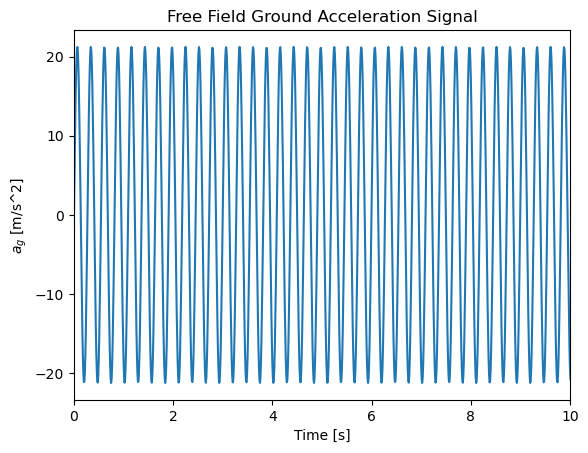

In [8]:
# SDOF Model 
m_modal = 1683     #[kg] modal mass
M_x = 3940         #[kg] effective translational modal mass in the x direction
J_y = 371117       #[kg*m^2] effective rotational modal mass about the y-axis (moment of inertia)
gamma_t = 2575.4   #[-] translational participation factor in the x direction
gamma_ry = 24995.1 #[-] rotation participation factor about the y-axis 
zeta_star = 0.048  #[-] modal damping ration (mode 2, arbitrarily assumed)

h_star = gamma_ry/gamma_t
c_star = 2*zeta_star*m_modal*omega
k_star = omega**2*M_x

rho_f = 2400 #[kg/m^3] Density of concrete (arbitrarily chosen)
m_f = rho_f*side_x*side_y*depth #[kg] Mass of foundation
J_y_f = m_f*(side_x**2+depth**2)/12 #[kg*m^2] Moment of Inertia of foundation about the y-axis

# Soil Dynamic Stiffness Matrix (reduced to the relevant degrees of freedom: horizontal (x), vertical (z), rotational (yr))
K_dyn_vec = [K_x_dyn, K_ry_dyn]
C_tot_vec = [C_x_tot, K_ry_dyn]
K_d = np.diag([k+1j*omega*c for k,c in zip(K_dyn_vec,C_tot_vec)])

print(f"h_star: {h_star:.3f} m")
print(f"c_star: {c_star:.3f} kg*rad/s")
print(f"k_star: {k_star:.3f} kg*rad^2/s^2")

# Acceleration
time_vec = np.arange(0,20,0.01)
a_g =  (a_g_ref_ms2 * S * eta * 2.5) * np.sin(omega*time_vec) #[m/s^2] (Amplitude is taken from the elastic spectrum, according to omega, and is applied to a sinusoid)
a_g_tilde = a_g_ref_ms2 #[(m/s^2)/Hz] Acceleration in the frequency domain (taken as unitary as a first analysis#?) 

K_tilde_system = np.zeros((3,3), dtype=complex)
K_tilde_system[0, 0] = -omega**2*M_x + 1j*omega*c_star + k_star
K_tilde_system[1, 1] = K_d[0,0] - omega**2*(M_x+m_f)
K_tilde_system[2, 2] = K_d[1,1] - omega**2*(M_x*h_star**2+J_y+J_y_f)
K_tilde_system[0, 1] = K_tilde_system[1, 0] = -omega**2*M_x
K_tilde_system[0, 2] = K_tilde_system[2, 0] = -omega**2*M_x*h_star
K_tilde_system[1, 2] = K_tilde_system[2, 1] = K_d[0,1] - omega**2*M_x*h_star

F_tilde = np.array([-M_x*a_g_tilde, -(M_x+m_f)*a_g_tilde, -M_x*h_star*a_g_tilde])

u_r_tilde, _ , _ = np.linalg.solve(K_tilde_system, F_tilde)

# u_r = np.

plt.plot(time_vec, a_g)
plt.title("Free Field Ground Acceleration Signal")
plt.xlabel("Time [s]")
plt.ylabel(r"$a_g$ [m/s^2]")
plt.xlim(0,10)

# plt.plot(time_vec, u_r)
# plt.title("Displacement of SDoF mass")
# plt.xlabel("Time [s]")
# plt.ylabel(r"$u^r$ [m]")
# plt.xlim(0,10)


